In [ ]:
!pip install segmentation-models;

In [2]:
import os
import pandas as pd
import tensorflow as tf
import segmentation_models as sm
import cv2
from cv2 import imread, resize
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import normalize
from tensorflow.keras.metrics import MeanIoU
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [3]:
seed = 42
np.random.seed = seed

In [4]:
def set_gpus():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

def get_gpus():
    info = device_lib.list_local_devices()
    return [x.physical_device_desc for x in info if x.device_type == "GPU"]

        
set_gpus()
get_gpus()

1 Physical GPUs, 1 Logical GPUs


['device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0']

In [5]:
dataset_path = "../input/camvid-dataset-modified/dataset"
class_desc = pd.read_csv(dataset_path + "/class_dict.csv", index_col=0)

In [6]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
NUM_CLASSES = len(class_desc) # 32


TRAIN_PATH = dataset_path + "/train"
TRAIN_LABELS_PATH = dataset_path + "/train_labels"
VAL_PATH = dataset_path + "/val"
VAL_LABELS_PATH = dataset_path + "/val_labels"

In [7]:
# Resizing the input images (for a sanity check)
train_size = len(os.listdir(TRAIN_PATH))
val_size = len(os.listdir(VAL_PATH))  

In [8]:
def resize_images(images_path, labels_path, size, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS):
    X = []
    y = []
    for idx, img_name in enumerate(os.listdir(images_path)[:size]):
        img_path = images_path + "/" + img_name
        img = imread(img_path)
        RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        RGB_img = resize(RGB_img, (IMG_HEIGHT, IMG_WIDTH))
        mask_path = labels_path + "/" + img_name[:-4] + "_L.png"
        mask = imread(mask_path)
        RGB_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        if(idx == 0):
            print("Original mask shape =", RGB_mask.shape)
        RGB_mask = resize(RGB_mask, (IMG_HEIGHT, IMG_WIDTH))
        if(idx == 0):
            print("Changed mask shape =", RGB_mask.shape)
        X.append(RGB_img)
        y.append(RGB_mask)
    
    print("Done!")
    return np.array(X), np.array(y)

In [9]:
# For training data
X_train, y_train = resize_images(TRAIN_PATH, TRAIN_LABELS_PATH, train_size, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
X_val, y_val = resize_images(VAL_PATH, VAL_LABELS_PATH, val_size, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

Original mask shape = (720, 960, 3)
Changed mask shape = (128, 128, 3)
Done!
Original mask shape = (720, 960, 3)
Changed mask shape = (128, 128, 3)
Done!


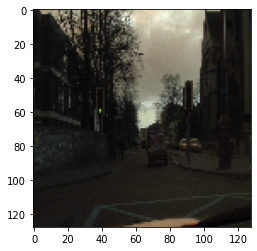

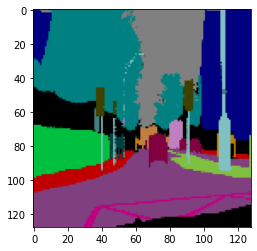

In [10]:
# Sanity check for images and masks
idx = np.random.randint(0, train_size)
img = cv2.cvtColor(X_train[idx], cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
img = cv2.cvtColor(y_train[idx], cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [12]:
cls2rgb = {cl:list(class_desc.loc[cl, :]) for cl in class_desc.index}
cls2rgb

{'Animal': [64, 128, 64],
 'Archway': [192, 0, 128],
 'Bicyclist': [0, 128, 192],
 'Bridge': [0, 128, 64],
 'Building': [128, 0, 0],
 'Car': [64, 0, 128],
 'CartLuggagePram': [64, 0, 192],
 'Child': [192, 128, 64],
 'Column_Pole': [192, 192, 128],
 'Fence': [64, 64, 128],
 'LaneMkgsDriv': [128, 0, 192],
 'LaneMkgsNonDriv': [192, 0, 64],
 'Misc_Text': [128, 128, 64],
 'MotorcycleScooter': [192, 0, 192],
 'OtherMoving': [128, 64, 64],
 'ParkingBlock': [64, 192, 128],
 'Pedestrian': [64, 64, 0],
 'Road': [128, 64, 128],
 'RoadShoulder': [128, 128, 192],
 'Sidewalk': [0, 0, 192],
 'SignSymbol': [192, 128, 128],
 'Sky': [128, 128, 128],
 'SUVPickupTruck': [64, 128, 192],
 'TrafficCone': [0, 0, 64],
 'TrafficLight': [0, 64, 64],
 'Train': [192, 64, 128],
 'Tree': [128, 128, 0],
 'Truck_Bus': [192, 128, 192],
 'Tunnel': [64, 0, 64],
 'VegetationMisc': [192, 192, 0],
 'Void': [0, 0, 0],
 'Wall': [64, 192, 0]}

In [13]:
def adjust_mask(mask, flat=False):
    semantic_map = []
    for colour in list(cls2rgb.values()):
        equality = np.equal(mask, colour)# 128 x 128 x 3 with True or False
        class_map = np.all(equality, axis = -1)# 128 x 128 If all True, then True, else False
        semantic_map.append(class_map)# List of 128 x 128 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 128 x 128 x 32 True only at the found color, and all False otherwise.
    if flat:
        semantic_map = np.reshape(semantic_map, (-1,IMG_HEIGHT*IMG_WIDTH))

    return np.float32(semantic_map)# convert to numbers

In [14]:
y_train_adj = adjust_mask(y_train)
y_val_adj = adjust_mask(y_val)

In [15]:
y_train_adj.shape

(601, 128, 128, 32)

In [16]:
activation = 'softmax'
LR = 0.0002
optim = tf.keras.optimizers.Adam(LR)

# cross_entropy_loss = sm.losses.CategoricalCELoss()
focal_loss = sm.losses.CategoricalFocalLoss()
dice_loss = sm.losses.DiceLoss()
total_loss = dice_loss + (1.5*focal_loss)

metrics= [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

BACKBONE = "inceptionv3"
preprocess_input = sm.get_preprocessing(BACKBONE)

callbacks_UNet = [
    tf.keras.callbacks.EarlyStopping(monitor='val_iou_score', mode="max", patience = 10, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath = "./UNet/", monitor="val_iou_score", mode="max", verbose = 1, save_best_only=True, save_weights_only=True)
]

callbacks_LinkNet = [
    tf.keras.callbacks.EarlyStopping(monitor='val_iou_score', mode="max", patience = 10, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath = "./LinkNet/", monitor="val_iou_score", mode="max", verbose = 1, save_best_only=True, save_weights_only=True)
]

callbacks_FPN = [
    tf.keras.callbacks.EarlyStopping(monitor='val_iou_score', mode="max", patience = 10, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath = "./FPN/", monitor="val_iou_score", mode="max", verbose = 1, save_best_only=True, save_weights_only=True)
]

X_train_process = preprocess_input(X_train)
X_val_process = preprocess_input(X_val)

In [17]:
def define_UNet(BACKBONE, activation, optimizer, loss, metrics):
    Model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=NUM_CLASSES, activation = activation)
    Model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return Model

def define_LinkNet(BACKBONE, activation, optimizer, loss, metrics):
    Model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=NUM_CLASSES, activation = activation)
    Model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return Model
    
# def define_PSPNet(BACKBONE, activation, optimizer, loss, metrics):
#     Model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=NUM_CLASSES, activation = activation)
#     Model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
def define_FPN(BACKBONE, activation, optimizer, loss, metrics):
    Model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=NUM_CLASSES, activation = activation)
    Model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return Model

In [18]:
UNet_Model = define_UNet(BACKBONE, activation, optim, total_loss, metrics)
LinkNet_Model = define_LinkNet(BACKBONE, activation, optim, total_loss, metrics)
FPN_Model = define_FPN(BACKBONE, activation, optim, total_loss, metrics)

87924736/87910968 [==============================] - 4s 0us/step


In [20]:
def train_UNet(callbacks, epochs = 20, batch_size = 8):
    print(f"Training the UNet Model")
    UNet_History = UNet_Model.fit(
        X_train_process,
        y_train_adj,
        callbacks = callbacks_UNet,
        epochs = epochs,
        batch_size = batch_size,
        verbose = 2,
        validation_data = (X_val_process, y_val_adj)
    )
    return UNet_History

def train_LinkNet(callbacks, epochs = 20, batch_size = 8):
    print(f"Training the LinkNet Model")
    LinkNet_History = LinkNet_Model.fit(
        X_train_process,
        y_train_adj,
        callbacks = callbacks_LinkNet,
        epochs = epochs,
        batch_size = batch_size,
        verbose = 2,
        validation_data = (X_val_process, y_val_adj)
    )
    return LinkNet_History
    
def train_FPN(callbacks, epochs = 20, batch_size = 8):
    print(f"Training the FPN Model")
    FPN_History = FPN_Model.fit(
        X_train_process,
        y_train_adj,
        callbacks = callbacks_FPN,
        epochs = epochs,
        batch_size = batch_size,
        verbose = 2,
        validation_data = (X_val_process, y_val_adj)
    )
    return FPN_History

In [21]:
UNet_History = train_UNet(callbacks_UNet, 100, 8)

Training the UNet Model
Epoch 1/100
76/76 - 28s - loss: 0.9639 - iou_score: 0.2701 - f1-score: 0.2824 - val_loss: 0.9140 - val_iou_score: 0.2994 - val_f1-score: 0.3223

Epoch 00001: val_iou_score improved from -inf to 0.29941, saving model to ./UNet/
Epoch 2/100
76/76 - 6s - loss: 0.8896 - iou_score: 0.3463 - f1-score: 0.3652 - val_loss: 0.9005 - val_iou_score: 0.3136 - val_f1-score: 0.3344

Epoch 00002: val_iou_score improved from 0.29941 to 0.31359, saving model to ./UNet/
Epoch 3/100
76/76 - 7s - loss: 0.8656 - iou_score: 0.3615 - f1-score: 0.3781 - val_loss: 0.8674 - val_iou_score: 0.3450 - val_f1-score: 0.3651

Epoch 00003: val_iou_score improved from 0.31359 to 0.34497, saving model to ./UNet/
Epoch 4/100
76/76 - 6s - loss: 0.8433 - iou_score: 0.3755 - f1-score: 0.3965 - val_loss: 0.8426 - val_iou_score: 0.3660 - val_f1-score: 0.3966

Epoch 00004: val_iou_score improved from 0.34497 to 0.36601, saving model to ./UNet/
Epoch 5/100
76/76 - 6s - loss: 0.8067 - iou_score: 0.4169 - f1

In [22]:
LinkNet_History = train_LinkNet(callbacks_LinkNet, 100, 8)

Training the LinkNet Model
Epoch 1/100
76/76 - 17s - loss: 0.9053 - iou_score: 0.3222 - f1-score: 0.3369 - val_loss: 1.0930 - val_iou_score: 0.2365 - val_f1-score: 0.2458

Epoch 00001: val_iou_score improved from -inf to 0.23648, saving model to ./LinkNet/
Epoch 2/100
76/76 - 6s - loss: 0.8343 - iou_score: 0.3814 - f1-score: 0.4078 - val_loss: 0.8715 - val_iou_score: 0.3357 - val_f1-score: 0.3662

Epoch 00002: val_iou_score improved from 0.23648 to 0.33571, saving model to ./LinkNet/
Epoch 3/100
76/76 - 6s - loss: 0.8041 - iou_score: 0.4074 - f1-score: 0.4390 - val_loss: 0.8079 - val_iou_score: 0.3906 - val_f1-score: 0.4268

Epoch 00003: val_iou_score improved from 0.33571 to 0.39065, saving model to ./LinkNet/
Epoch 4/100
76/76 - 7s - loss: 0.7709 - iou_score: 0.4245 - f1-score: 0.4663 - val_loss: 0.7782 - val_iou_score: 0.3981 - val_f1-score: 0.4443

Epoch 00004: val_iou_score improved from 0.39065 to 0.39809, saving model to ./LinkNet/
Epoch 5/100
76/76 - 6s - loss: 0.7338 - iou_sco

In [23]:
FPN_History = train_FPN(callbacks_FPN, 100, 8)

Training the FPN Model
Epoch 1/100
76/76 - 16s - loss: 0.8928 - iou_score: 0.3358 - f1-score: 0.3566 - val_loss: 0.9481 - val_iou_score: 0.2747 - val_f1-score: 0.2984

Epoch 00001: val_iou_score improved from -inf to 0.27472, saving model to ./FPN/
Epoch 2/100
76/76 - 6s - loss: 0.8186 - iou_score: 0.3942 - f1-score: 0.4223 - val_loss: 0.8453 - val_iou_score: 0.3630 - val_f1-score: 0.3952

Epoch 00002: val_iou_score improved from 0.27472 to 0.36304, saving model to ./FPN/
Epoch 3/100
76/76 - 6s - loss: 0.7745 - iou_score: 0.4319 - f1-score: 0.4741 - val_loss: 0.7962 - val_iou_score: 0.4110 - val_f1-score: 0.4587

Epoch 00003: val_iou_score improved from 0.36304 to 0.41104, saving model to ./FPN/
Epoch 4/100
76/76 - 6s - loss: 0.7360 - iou_score: 0.4605 - f1-score: 0.5140 - val_loss: 0.7476 - val_iou_score: 0.4410 - val_f1-score: 0.4990

Epoch 00004: val_iou_score improved from 0.41104 to 0.44103, saving model to ./FPN/
Epoch 5/100
76/76 - 6s - loss: 0.7082 - iou_score: 0.4680 - f1-scor

In [24]:
models = [UNet_Model, LinkNet_Model, FPN_Model]
model_names = ["UNet", "LinkNet", "FPN"]
histories = [UNet_History, LinkNet_History, FPN_History]

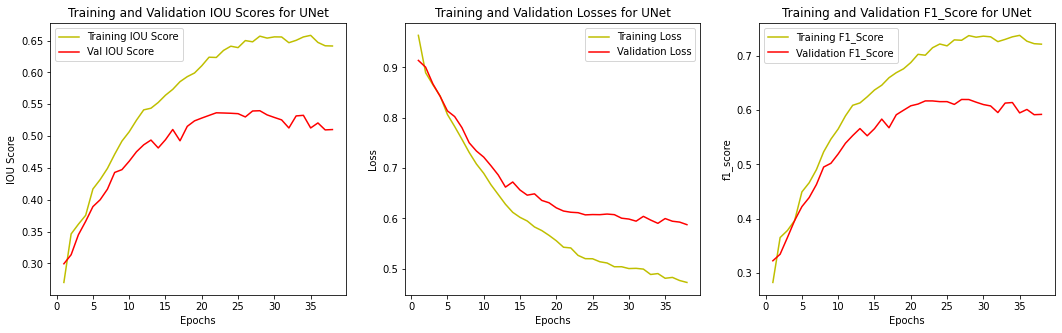

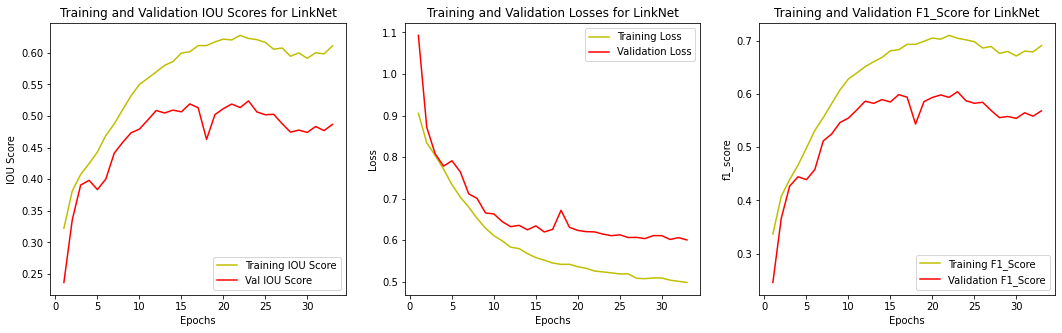

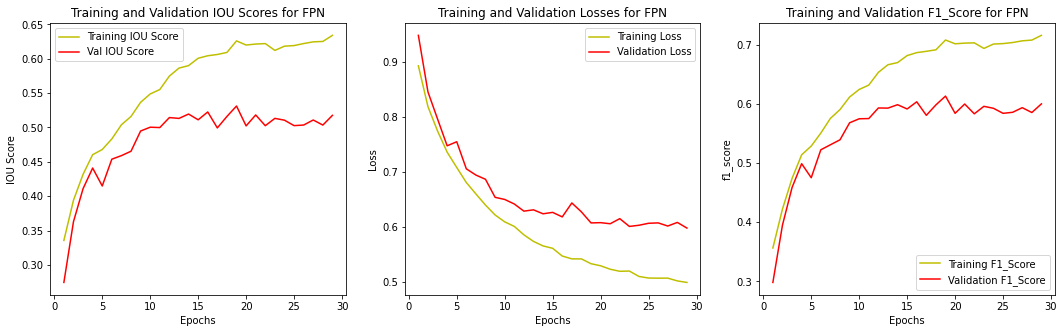

In [25]:
for i in range(len(models)):
    iou_score = histories[i].history['iou_score']
    val_iou_score = histories[i].history['val_iou_score']
    epochs = range(1, len(iou_score)+1)
    fig, axs = plt.subplots(1, 3, figsize = (18, 5))
    axs[0].plot(epochs, iou_score, 'y', label='Training IOU Score')
    axs[0].plot(epochs, val_iou_score, 'r', label='Val IOU Score')
    axs[0].set_title(f"Training and Validation IOU Scores for {model_names[i]}")
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel("IOU Score")
    axs[0].legend()
    
    loss = histories[i].history['loss']
    val_loss = histories[i].history['val_loss']
    axs[1].plot(epochs, loss, 'y', label='Training Loss')
    axs[1].plot(epochs, val_loss, 'r', label='Validation Loss')
    axs[1].set_title(f"Training and Validation Losses for {model_names[i]}")
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    f1_score = histories[i].history['f1-score']
    val_f1_score = histories[i].history['val_f1-score']
    axs[2].plot(epochs, f1_score, 'y', label='Training F1_Score')
    axs[2].plot(epochs, val_f1_score, 'r', label='Validation F1_Score')
    axs[2].set_title(f"Training and Validation F1_Score for {model_names[i]}")
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel("f1_score")
    axs[2].legend()

In [26]:
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}

def map_class_to_rgb(p):
  return idx2rgb[p[0]]

In [27]:
def predict_mask(img, model):
    "Given an image of size (128, 128, 3), predict the segmented mask of img by the model."
    test_img = img.reshape((1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    prediction = (model.predict(test_img))
    prediction = np.argmax(prediction, axis=-1)
    rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(prediction, -1))
    rgb_mask = rgb_mask.reshape((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    return rgb_mask

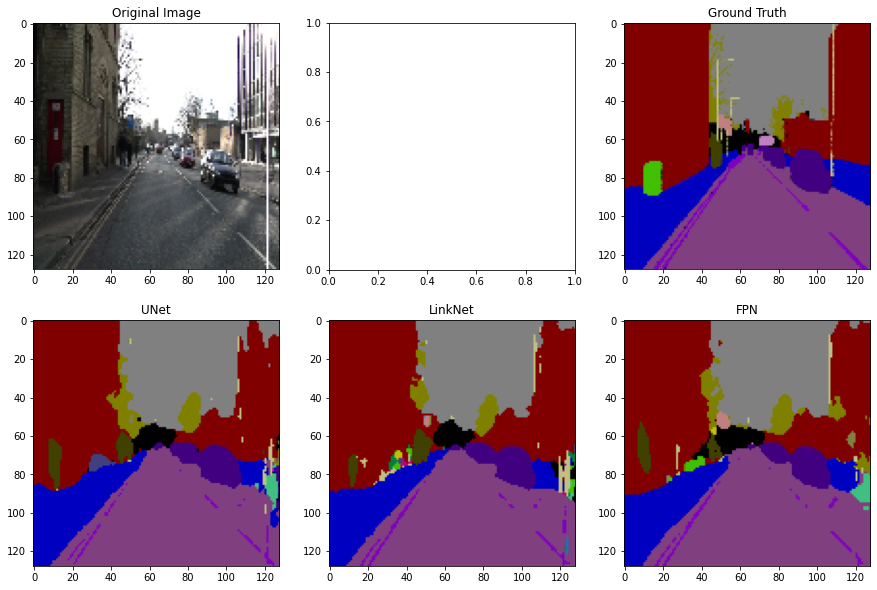

In [28]:
idx = np.random.randint(0, len(X_val))

fig, axs = plt.subplots(2, 3, figsize = (15, 10))
axs[0, 0].set_title("Original Image")
axs[0, 0].imshow(X_val[idx])
axs[0, 2].set_title("Ground Truth")
axs[0, 2].imshow(y_val[idx])
axs[1, 0].set_title(model_names[0])
axs[1, 0].imshow(predict_mask(X_val_process[idx], models[0]))
axs[1, 1].set_title(model_names[1])
axs[1, 1].imshow(predict_mask(X_val_process[idx], models[1]))
axs[1, 2].set_title(model_names[2])
axs[1, 2].imshow(predict_mask(X_val_process[idx], models[2]))